## Continuous T1 

This reads out the state of the qubit at t = T1 continuously. We recalibrate the qubit after some variable time. The qubit is assumed to be calibrated and the data saved to the cfg file 

# ------------ Initializations ------------

In [45]:
# %matplotlib widget
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
import scipy as sp
import json
import cProfile
import re 
import datetime
from timeit import default_timer as timer

from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
from datetime import datetime
import h5py


# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas


In [47]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [48]:
expt_path=os.getcwd()+'\data'
data_path = "C:\_Data\LLqub_contT1"
print('Continuous T1 Data will be stored in', data_path)
print('SLAB data will be stored in', expt_path) 

Continuous T1 Data will be stored in C:\_Data\LLqub_contT1
SLAB data will be stored in c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data


Import the cfg file: 

In [49]:
import yaml
# Results config file:
results_config_file = 'autocalibration_cfg.yml'
results_config_path = os.getcwd() + '\\' + results_config_file
print('Results config will be', results_config_path)

# open the file 
with open(results_config_file,'r') as file:
  auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

def save_edits( file_name, edit_config, edit_list, qubit_i,  value):
    print('Assumes edit_list is already in edit_config')
    print('If it is not, it will not update edit_config')
    # open the file 
    # edit the file
    edit_list[qubit_i] = value
    # dump it: 
    edit_config= yaml.safe_dump(edit_config.to_dict(), default_flow_style=  True)

    # write it: 
    with open(file_name, 'w') as modified_file:
        modified_file.write(edit_config)

    # now, open the modified file again 
    with open(file_name,'r') as file:
      edit_config=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 
    return edit_config

Results config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\autocalibration_cfg.yml


In [55]:
#im = InstrumentManager(ns_address='192.168.137.200') # SLAC lab
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
# find ip adddress qick, go to the web address, run it's 


KeyError: 'Qick99'

In [54]:
auto_cfg['aliases']['soc']='Qick99'

In [ ]:

print(soc)
print(auto_cfg['aliases']['soc'])
print(soc.description())


215 307
readout freq 0 +/- 7098.022026730655


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00032_adc_trig_offset_calibration_qubit0.h5


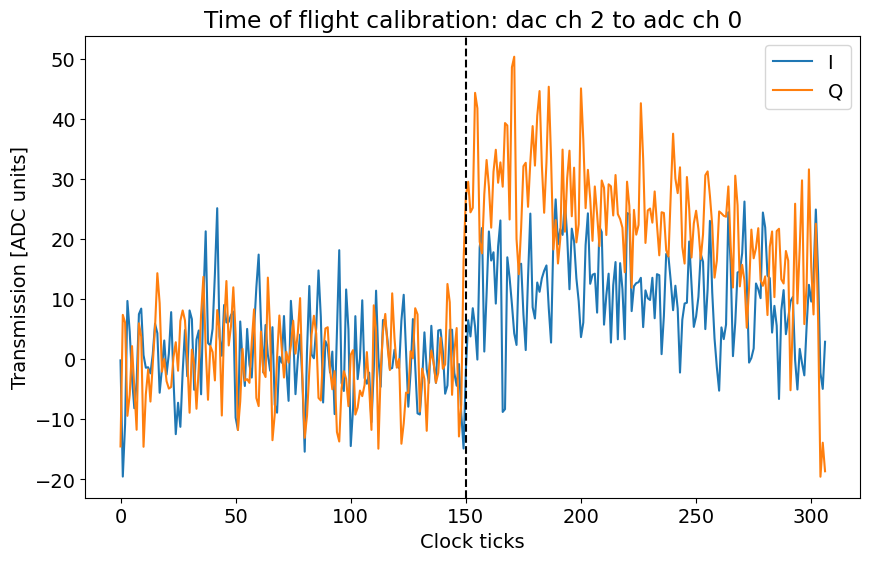

In [ ]:
qubit_i = 0
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=results_config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    gain=30000, # blast the power just for the RFSoC calibration
    # gain=5000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]

import Pyro4.util
try: 
    tof.go(analyze=False, display=False, progress=True, save=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

tof.display(adc_trig_offset=150) 

## Run the T1 with recalibration 

In [14]:
def run_continuous_t1(qubit_i):
    t1_cont = meas.T1Continuous(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_continuous_qubit{qubit_i}",
        config_file=results_config_path,
    )

    span = auto_cfg.device.qubit.T1[qubit_i]
    npts = 1

    t1_cont.cfg.expt = dict(
        start=span / npts,  # wait time [us]
        step=0,
        expts=npts,
        reps=  1000000, #1000000,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
    )

    t1_cont.go(analyze=False, display=False, progress=True, save=False)
    t1_raw_i = t1_cont.data['raw_i']
    t1_raw_q = t1_cont.data['raw_q']
    t1_amps = t1_cont.data['raw_amps']

    return t1_raw_i, t1_raw_q, t1_amps
pass

def run_t1_recalibration(qubit_i):
    t1 = meas.T1Experiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_qubit{qubit_i}",
        config_file=results_config_path,
        )

    span = 600 
    npts = 100 #100

    t1.cfg.expt = dict(
        start=0,  # wait time [us]
        step=int(span / npts),
        expts=npts,
        reps= 100*5, #100*5,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
        length_scan=span,  # length of the scan in us
        num_saved_points=1,  # number of points to save for the T1 continuous scan
        )

    t1.go(analyze=False, display=False, progress=True, save=False)
    t1.analyze(fit=True)
    t1_err_i = np.sqrt(t1.data['fit_err_avgi'][3][3])
    t1_fit_i =t1.data['fit_avgi'][3]
    err_ratio_i = t1_err_i/t1_fit_i

    t1_err_q = np.sqrt(t1.data['fit_err_avgq'][3][3])
    t1_fit_q =t1.data['fit_avgq'][3]
    err_ratio_q = t1_err_q/t1_fit_q

    # open the results config file 
    with open(results_config_file,'r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    if err_ratio_i< err_ratio_q:
        print('t1_i is better, saving T1_i to results cfg file') 
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_i)  # [DAC units]  

    else: 
        print('t1_q is better, saving t1_q to results cfg file')
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_q)  # [DAC units]  

    auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

    # write it: 
    with open('autocalibration_cfg.yml', 'w') as modified_file:
        modified_file.write(auto_cfg)
    # now, open the modified file again 
    with open('autocalibration_cfg.yml','r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary
    
    t1_xpts = t1.data['xpts']
    t1_i = t1.data['avgi']
    t1_q = t1.data['avgq']
    t1_amp = t1.data['amps']
    t1_i_value = t1.data['fit_avgi'][3]
    t1_q_value = t1.data['fit_avgq'][3]
    t1_amp_value = t1.data['fit_amps'][3]
    t1_i_value_err = t1.data['fit_err_avgi'][3][3]
    t1_q_value_err = t1.data['fit_err_avgq'][3][3]
    t1_amp_value_err = t1.data['fit_err_amps'][3][3]

    return t1_xpts, t1_i, t1_q, t1_amp, t1_i_value, t1_q_value, t1_amp_value, t1_i_value_err, t1_q_value_err, t1_amp_value_err
pass

def run_single_shot(qubit_i):
    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file= results_config_path,
    )

    shot.cfg.expt = dict(
        reps=40000, #40000
        check_e = True, 
        check_f=False,
        qubit=0,
    )

    shot.go(analyze=False, display=False, progress=True, save=True)
    shot.analyze(verbose=False)

    rotation_angle = shot.data['angle']
    print(rotation_angle)
    threshold = shot.data['thresholds'][0]
    print(threshold)

    fidelity = shot.data['fids'][0]*100
    Ig = shot.data['Ig']
    Qg = shot.data['Qg']
    Ie = shot.data['Ie']
    Qe = shot.data['Qe']

     # open the results config file 
    with open(results_config_file,'r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    auto_cfg.device.readout.phase[qubit_i] = float(rotation_angle) # degrees
    # auto_cfg.device.readout.threshold[qubit_i] = float(threshold) # [DAC units]

    auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

    # write it: 
    with open('autocalibration_cfg.yml', 'w') as modified_file:
        modified_file.write(auto_cfg)
    # now, open the modified file again 
    with open('autocalibration_cfg.yml','r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    return rotation_angle, threshold, fidelity, Ig, Qg, Ie, Qe

def main():
    # Get the current date and time
    import datetime 
    from datetime import datetime
    
    current_datetime = datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the filename using the formatted date and time
    filename = os.path.join(data_path, f"{formatted_datetime}.h5")

    # Create an HDF5 file to save all the data
    hf = h5py.File(filename, 'a')

    if 't1_cont' not in hf:
        g1 = hf.create_group('t1_cont')
        # g1.create_dataset('time', data=np.array([]), maxshape=(None,))
        g1.create_dataset('i', data=np.array([]), maxshape=(None,))
        g1.create_dataset('q', data=np.array([]), maxshape=(None,))
        g1.create_dataset('amp', data=np.array([]), maxshape=(None,))

    if 't1_recal' not in hf:
        g2 = hf.create_group('t1_recal')
        g2.create_dataset('time', data = np.array([]), maxshape=(None,))
        g2.create_dataset('xpts', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value_err', data=np.array([]), maxshape=(None,))
    
    if 'single_shot' not in hf:
        g3 = hf.create_group('single_shot')
        g3.create_dataset('time', data = np.array([]), maxshape=(None,))
        g3.create_dataset('angle', data=np.array([]), maxshape=(None,))
        g3.create_dataset('threshold', data=np.array([]), maxshape=(None,))
        g3.create_dataset('fidelity', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Ig', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Qg', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Ie', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Qe', data=np.array([]), maxshape=(None,))

    qubit_i = 0
    # Initialize arrays
    t1_raw_i_data, t1_raw_q_data, t1_amps_data = np.array([]), np.array([]), np.array([])
    
    t1_xpts_recal_data, t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err= np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]) , np.array([])

    angle_recal, threshold_recal, fidelity_recal, Ig_recal, Qg_recal, Ie_recal, Qe_recal = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    start_time = timer()
    try:
        while True:
        
            t1_raw_i_data, t1_raw_q_data, t1_amps_data = run_continuous_t1(qubit_i)

            # Append new data to datasets
            hf['t1_cont/i'].resize((hf['t1_cont/i'].shape[0] + t1_raw_i_data.shape[0]), axis=0)
            hf['t1_cont/i'][-t1_raw_i_data.shape[0]:] = t1_raw_i_data

            hf['t1_cont/q'].resize((hf['t1_cont/q'].shape[0] + t1_raw_q_data.shape[0]), axis=0)
            hf['t1_cont/q'][-t1_raw_q_data.shape[0]:] = t1_raw_q_data

            hf['t1_cont/amp'].resize((hf['t1_cont/amp'].shape[0] + t1_amps_data.shape[0]), axis=0)
            hf['t1_cont/amp'][-t1_amps_data.shape[0]:] = t1_amps_data
           
            print('Continuous data appended to', filename)

            end_time = timer()

            if end_time - start_time >= 60*30: #60*30
                # now = datetime.now()
                # current_time = now.strftime("%H:%M:%S")
                # # current_time = current_time.encode('ascii','replace')

                # # Run the continuous T1 experiment
                # hf['t1_recal/time'].resize((hf['t1_recal/time'].shape[0] + 1), axis=0)
                # hf['t1_recal/time'][-1:] = current_datetime
                # current_time = time.time()
                # t1_time_recal_data = np.append(t1_time_recal_data, current_time)
                
                print(f"{end_time - start_time} seconds have passed. Running T1 recalibration.")

                # Run the T1 recalibration experiment
                t1_xpts_recal_data, t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err = run_t1_recalibration(qubit_i)

                print(t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data)

                # print(np.shape(t1_i_value_recal_data), np.shape(t1_q_value_recal_data), np.shape(t1_amp_value_recal_data))
                hf['t1_recal/time'].resize((hf['t1_recal/time'].shape[0] + 1), axis=0) 
                hf['t1_recal/time'][-1:] = time.time() 
                
                hf['t1_recal/xpts'].resize((hf['t1_recal/xpts'].shape[0] + t1_xpts_recal_data.shape[0]), axis=0)
                hf['t1_recal/xpts'][-t1_xpts_recal_data.shape[0]:] = t1_xpts_recal_data

                hf['t1_recal/i'].resize((hf['t1_recal/i'].shape[0] + t1_i_recal_data.shape[0]), axis=0)
                hf['t1_recal/i'][-t1_i_recal_data.shape[0]:] = t1_i_recal_data

                hf['t1_recal/q'].resize((hf['t1_recal/q'].shape[0] + t1_q_recal_data.shape[0]), axis=0)
                hf['t1_recal/q'][-t1_q_recal_data.shape[0]:] = t1_q_recal_data

                hf['t1_recal/amp'].resize((hf['t1_recal/amp'].shape[0] + t1_amp_recal_data.shape[0]), axis=0)
                hf['t1_recal/amp'][-t1_amp_recal_data.shape[0]:] = t1_amp_recal_data

                # T1 values for I, Q, and amp: 
                hf['t1_recal/i_value'].resize((hf['t1_recal/i_value'].shape[0] + 1), axis=0)
                hf['t1_recal/i_value'][-1:] = t1_i_value_recal_data

                hf['t1_recal/q_value'].resize((hf['t1_recal/q_value'].shape[0] + 1), axis=0)
                hf['t1_recal/q_value'][-1:] = t1_q_value_recal_data

                hf['t1_recal/amp_value'].resize((hf['t1_recal/amp_value'].shape[0] + 1), axis=0)
                hf['t1_recal/amp_value'][-1:] = t1_amp_value_recal_data

                # T1 errors for I, Q, and amp:  
                hf['t1_recal/i_value_err'].resize((hf['t1_recal/i_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/i_value_err'][-1:] = t1_i_value_recal_data_err

                hf['t1_recal/q_value_err'].resize((hf['t1_recal/q_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/q_value_err'][-1:] = t1_q_value_recal_data_err

                hf['t1_recal/amp_value_err'].resize((hf['t1_recal/amp_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/amp_value_err'][-1:] = t1_amp_value_recal_data_err

                # Run the single shot recalibration 
                angle_recal, threshold_recal, fidelity_recal, Ig_recal, Qg_recal, Ie_recal, Qe_recal  = run_single_shot(qubit_i)

                hf['single_shot/time'].resize((hf['single_shot/time'].shape[0] + 1), axis=0) 
                hf['single_shot/time'][-1:] = time.time() 
                hf['single_shot/angle'].resize((hf['single_shot/angle'].shape[0] + 1), axis=0)
                hf['single_shot/angle'][-1:] = angle_recal
                hf['single_shot/threshold'].resize((hf['single_shot/threshold'].shape[0] + 1), axis=0)
                hf['single_shot/threshold'][-1:] = threshold_recal
                hf['single_shot/fidelity'].resize((hf['single_shot/fidelity'].shape[0] + 1), axis=0)
                hf['single_shot/fidelity'][-1:] = fidelity_recal
                print('new anle, threshold, and fidelity', angle_recal, threshold_recal, fidelity_recal)
                
                # I and Q values for shots
                hf['single_shot/Ig'].resize((hf['single_shot/Ig'].shape[0] + Ig_recal.shape[0]), axis=0)
                hf['single_shot/Ig'][-Ig_recal.shape[0]:] = Ig_recal

                hf['single_shot/Qg'].resize((hf['single_shot/Qg'].shape[0] + Qg_recal.shape[0]), axis=0)
                hf['single_shot/Qg'][-Qg_recal.shape[0]:] = Qg_recal

                hf['single_shot/Ie'].resize((hf['single_shot/Ie'].shape[0] + Ie_recal.shape[0]), axis=0)
                hf['single_shot/Ie'][-Ie_recal.shape[0]:] = Ie_recal

                hf['single_shot/Qe'].resize((hf['single_shot/Qe'].shape[0] + Qe_recal.shape[0]), axis=0)
                hf['single_shot/Qe'][-Qe_recal.shape[0]:] = Qe_recal

                print('Recalibration data appended to', filename)
                start_time = timer()  # Reset the start time

    except KeyboardInterrupt:
        # If KeyboardInterrupt (Ctrl+C) is detected, close the HDF5 file
        hf.close()
        print("Program stopped. HDF5 file closed.")
 
if __name__ == "__main__":
    main()


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.5479680999997 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
159.85351163959018 168.43290917337586 159.22598415596858
using phase reset
<Pyro4.core.Proxy at 0x28b4287d5a0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00209_single_shot_qubit0.h5
-16.686338540450492
8.545817562988677
new anle, threshold, and fidelity -16.686338540450492 8.545817562988677 84.02460061501537
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.405422799995 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
114.02897631047942 125.88281138074096 113.56228259372612
using phase reset
<Pyro4.core.Proxy at 0x28b45a76080; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00210_single_shot_qubit0.h5
-12.937576499026823
8.457203006827596
new anle, threshold, and fidelity -12.937576499026823 8.457203006827596 83.52104401305016
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4337842999958 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.18520058453834 329.4361999213035 118.51858748757631
using phase reset
<Pyro4.core.Proxy at 0x28b45ad0ac0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00211_single_shot_qubit0.h5
-8.716473432174093
8.150951192177484
new anle, threshold, and fidelity -8.716473432174093 8.150951192177484 84.30710767769195
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.408737000005 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
138.90304367727447 155.14838949486338 138.7060217078447
using phase reset
<Pyro4.core.Proxy at 0x28b45ad3340; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00212_single_shot_qubit0.h5
-2.69496570478852
8.029268838156868
new anle, threshold, and fidelity -2.69496570478852 8.029268838156868 83.0020750518763
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4481037000005 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.62076904695374 229.74646229455058 145.00375075402633
using phase reset
<Pyro4.core.Proxy at 0x28b45d314e0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00213_single_shot_qubit0.h5
1.8022158842874612
7.922869287644804
new anle, threshold, and fidelity 1.8022158842874612 7.922869287644804 83.82104776309703
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4143525000036 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
122.17674217339506 153.2591090885335 121.6641969796563
using phase reset
<Pyro4.core.Proxy at 0x28b45d69780; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00214_single_shot_qubit0.h5
8.54695469814863
8.13008478584661
new anle, threshold, and fidelity 8.54695469814863 8.13008478584661 83.23354041925523
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4239486000006 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
141.51851207117315 190.81236138196806 140.2619387066786
using phase reset
<Pyro4.core.Proxy at 0x28b45da6560; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00215_single_shot_qubit0.h5
11.562542858329525
8.070236288388553
new anle, threshold, and fidelity 11.562542858329525 8.070236288388553 83.10103876298453
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4325788999995 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
162.0154652061243 258.82122494573923 160.55189960263627
using phase reset
<Pyro4.core.Proxy at 0x28b45da4c70; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00216_single_shot_qubit0.h5
13.74680461036758
7.8500762241300315
new anle, threshold, and fidelity 13.74680461036758 7.8500762241300315 83.60854510681384
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4075345999954 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
143.84103263939835 33472.54313665281 143.26341987289481
using phase reset
<Pyro4.core.Proxy at 0x28b45e129b0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00217_single_shot_qubit0.h5
12.783696105270932
7.627720085719433
new anle, threshold, and fidelity 12.783696105270932 7.627720085719433 81.65602070025876
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.401227800001 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.24997217725482 109.7696071839069 149.0515009183938
using phase reset
<Pyro4.core.Proxy at 0x28b45e13670; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00218_single_shot_qubit0.h5
9.793574099460933
8.026936952719375
new anle, threshold, and fidelity 9.793574099460933 8.026936952719375 82.91103638795485
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.403361600009 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.94136312438567 689.2785596474627 157.80924837178185
using phase reset
<Pyro4.core.Proxy at 0x28b45e12800; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00219_single_shot_qubit0.h5
8.144838836883624
8.003499122944847
new anle, threshold, and fidelity 8.144838836883624 8.003499122944847 83.17957948948724
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.372033300009 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
134.00524472479128 175.0820359651023 132.93244838530538
using phase reset
<Pyro4.core.Proxy at 0x28b45e57f70; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00220_single_shot_qubit0.h5
6.767213418228559
7.972052577264094
new anle, threshold, and fidelity 6.767213418228559 7.972052577264094 83.12811730439891
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.404152300005 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\experiments\fitting.py:65: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


t1_i is better, saving T1_i to results cfg file
133.74417258175504 135.64011689204946 132.9745399600199
using phase reset
<Pyro4.core.Proxy at 0x28b45e125f0; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00221_single_shot_qubit0.h5
5.99387771288135
7.782677066838225
new anle, threshold, and fidelity 5.99387771288135 7.782677066838225 83.48813080490518
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4181151000084 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
154.83794147262296 87.17876967301088 153.79842782321106
using phase reset
<Pyro4.core.Proxy at 0x28b45e57f70; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00222_single_shot_qubit0.h5
5.874578483862119
8.048470625839503
new anle, threshold, and fidelity 5.874578483862119 8.048470625839503 83.37958448961224
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.3833879999875 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
145.86113640190473 178471.3143169138 144.19101049632985
using phase reset
<Pyro4.core.Proxy at 0x28b45e54e20; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00223_single_shot_qubit0.h5
5.2619162713308025
7.954227195402229
new anle, threshold, and fidelity 5.2619162713308025 7.954227195402229 82.34602932536657
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4167405999906 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
131.49646669209434 421.2777225154416 131.45905538455577
using phase reset
<Pyro4.core.Proxy at 0x28b45e55b40; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00224_single_shot_qubit0.h5
3.6198437547134867
7.786673750422734
new anle, threshold, and fidelity 3.6198437547134867 7.786673750422734 77.73347166839586
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4235415000003 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
155.05751665854038 73.67056793178864 154.2596940006472
using phase reset
<Pyro4.core.Proxy at 0x28b47003c40; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00225_single_shot_qubit0.h5
3.489348465054299
7.550826421286619
new anle, threshold, and fidelity 3.489348465054299 7.550826421286619 78.17195429885747
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.41866190001 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
58.9331963592794 5.515736667414146 58.83131847394155
using phase reset
<Pyro4.core.Proxy at 0x28b45e13610; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00226_single_shot_qubit0.h5
3.603398483196673
7.514451064554347
new anle, threshold, and fidelity 3.603398483196673 7.514451064554347 73.67842098026225
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.3939519999985 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
77.7800386697548 243985.98549838807 76.96759013682671
using phase reset
<Pyro4.core.Proxy at 0x28b47078880; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00227_single_shot_qubit0.h5
2.199695700498655
8.135433398533912
new anle, threshold, and fidelity 2.199695700498655 8.135433398533912 80.02850035625445
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.399719000008 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
140.80804016483873 158.55904500462515 138.98095918647175
using phase reset
<Pyro4.core.Proxy at 0x28b45e10670; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00228_single_shot_qubit0.h5
1.841952475789334
7.993276546226465
new anle, threshold, and fidelity 1.841952475789334 7.993276546226465 81.69352116901462
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.3944925000105 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
55.2805501694186 -10.951156945323078 54.37930977914691
using phase reset
<Pyro4.core.Proxy at 0x28b45e10970; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00229_single_shot_qubit0.h5
-0.024695852623475525
8.181372874245884
new anle, threshold, and fidelity -0.024695852623475525 8.181372874245884 82.7085338566732
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5
3283.4013985000056 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
119.53488375541455 104.24575846147764 118.77084699778761
using phase reset
<Pyro4.core.Proxy at 0x28b45f17730; not connected; for PYRO:obj_e0a12d402d674a73a40b28fdfe13addf@192.168.137.233:40721>


  0%|          | 0/40000 [00:00<?, ?it/s]

using phase reset


  0%|          | 0/40000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00230_single_shot_qubit0.h5
0.4280911092834145
8.15785098346333
new anle, threshold, and fidelity 0.4280911092834145 8.15785098346333 83.07603845048062
Recalibration data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-03-13_10-51-23.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Program stopped. HDF5 file closed.


In [37]:
with open(results_config_file,'r') as file:
    auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

auto_cfg.device.readout.phase[qubit_i] = -7.844325608133489 # degrees
auto_cfg.device.readout.threshold[qubit_i] = 57.221847452942725 # [DAC units]

auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

# write it: 
with open('autocalibration_cfg.yml', 'w') as modified_file:
    modified_file.write(auto_cfg)
# now, open the modified file again 
with open('autocalibration_cfg.yml','r') as file:
    auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

In [11]:
import time
now = time.time()
readabel = datetime.fromtimestamp(now).isoformat()
print(readabel)

# 


2024-03-13T10:06:14.004350


## Just T1 

In [1]:

def run_t1_recalibration(qubit_i):
    t1 = meas.T1Experiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_qubit{qubit_i}",
        config_file=results_config_path,
        )

    span = 600 
    npts = 30 #100

    t1.cfg.expt = dict(
        start=0,  # wait time [us]
        step=int(span / npts),
        expts=npts,
        reps= 100*2, #100*5,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
        length_scan=span,  # length of the scan in us
        num_saved_points=1,  # number of points to save for the T1 continuous scan
        )


    t1.go(analyze=False, display=False, progress=True, save=False)
    t1.analyze(fit=True)
    t1_err_i = np.sqrt(t1.data['fit_err_avgi'][3][3])
    t1_fit_i =t1.data['fit_avgi'][3]
    err_ratio_i = t1_err_i/t1_fit_i

    t1_err_q = np.sqrt(t1.data['fit_err_avgq'][3][3])
    t1_fit_q =t1.data['fit_avgq'][3]
    err_ratio_q = t1_err_q/t1_fit_q

    # open the results config file 
    with open(results_config_file,'r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    if err_ratio_i< err_ratio_q:
        print('t1_i is better, saving T1_i to results cfg file') 
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_i)  # [DAC units]  

    else: 
        print('t1_q is better, saving t1_q to results cfg file')
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_q)  # [DAC units]  

    auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

    # write it: 
    with open('autocalibration_cfg.yml', 'w') as modified_file:
        modified_file.write(auto_cfg)
    # now, open the modified file again 
    with open('autocalibration_cfg.yml','r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary
    
    t1_xpts = t1.data['xpts']
    t1_i = t1.data['avgi']
    t1_q = t1.data['avgq']
    t1_amp = t1.data['amps']
    t1_i_value = t1.data['fit_avgi'][3]
    t1_q_value = t1.data['fit_avgq'][3]
    t1_amp_value = t1.data['fit_amps'][3]
    t1_i_value_err = t1.data['fit_err_avgi'][3][3]
    t1_q_value_err = t1.data['fit_err_avgq'][3][3]
    t1_amp_value_err = t1.data['fit_err_amps'][3][3]

    return t1_xpts, t1_i, t1_q, t1_amp, t1_i_value, t1_q_value, t1_amp_value, t1_i_value_err, t1_q_value_err, t1_amp_value_err
pass


def main():
    # Get the current date and time
    import datetime 
    from datetime import datetime
    
    current_datetime = datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the filename using the formatted date and time
    filename = os.path.join(data_path, f"t1_full{formatted_datetime}.h5")

    # Create an HDF5 file to save all the data
    hf = h5py.File(filename, 'a')


    if 't1_recal' not in hf:
        g2 = hf.create_group('t1_recal')
        g2.create_dataset('time', data = np.array([]), maxshape=(None,))
        g2.create_dataset('xpts', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value_err', data=np.array([]), maxshape=(None,))
    
  

    qubit_i = 0
   
    t1_xpts_recal_data, t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err= np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]) , np.array([])

    try:
        while True:

            # Run the T1 recalibration experiment
            t1_xpts_recal_data, t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err = run_t1_recalibration(qubit_i)

            print(t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data)

            hf['t1_recal/time'].resize((hf['t1_recal/time'].shape[0] + 1), axis=0) 
            hf['t1_recal/time'][-1:] = time.time() 
            
            hf['t1_recal/xpts'].resize((hf['t1_recal/xpts'].shape[0] + t1_xpts_recal_data.shape[0]), axis=0)
            hf['t1_recal/xpts'][-t1_xpts_recal_data.shape[0]:] = t1_xpts_recal_data

            hf['t1_recal/i'].resize((hf['t1_recal/i'].shape[0] + t1_i_recal_data.shape[0]), axis=0)
            hf['t1_recal/i'][-t1_i_recal_data.shape[0]:] = t1_i_recal_data

            hf['t1_recal/q'].resize((hf['t1_recal/q'].shape[0] + t1_q_recal_data.shape[0]), axis=0)
            hf['t1_recal/q'][-t1_q_recal_data.shape[0]:] = t1_q_recal_data

            hf['t1_recal/amp'].resize((hf['t1_recal/amp'].shape[0] + t1_amp_recal_data.shape[0]), axis=0)
            hf['t1_recal/amp'][-t1_amp_recal_data.shape[0]:] = t1_amp_recal_data

            # T1 values for I, Q, and amp: 
            hf['t1_recal/i_value'].resize((hf['t1_recal/i_value'].shape[0] + 1), axis=0)
            hf['t1_recal/i_value'][-1:] = t1_i_value_recal_data

            hf['t1_recal/q_value'].resize((hf['t1_recal/q_value'].shape[0] + 1), axis=0)
            hf['t1_recal/q_value'][-1:] = t1_q_value_recal_data

            hf['t1_recal/amp_value'].resize((hf['t1_recal/amp_value'].shape[0] + 1), axis=0)
            hf['t1_recal/amp_value'][-1:] = t1_amp_value_recal_data

            # T1 errors for I, Q, and amp:  
            hf['t1_recal/i_value_err'].resize((hf['t1_recal/i_value_err'].shape[0] + 1), axis=0)
            hf['t1_recal/i_value_err'][-1:] = t1_i_value_recal_data_err

            hf['t1_recal/q_value_err'].resize((hf['t1_recal/q_value_err'].shape[0] + 1), axis=0)
            hf['t1_recal/q_value_err'][-1:] = t1_q_value_recal_data_err

            hf['t1_recal/amp_value_err'].resize((hf['t1_recal/amp_value_err'].shape[0] + 1), axis=0)
            hf['t1_recal/amp_value_err'][-1:] = t1_amp_value_recal_data_err

            print('Recalibration data appended to', filename)

    except KeyboardInterrupt:
        # If KeyboardInterrupt (Ctrl+C) is detected, close the HDF5 file
        hf.close()
        print("Program stopped. HDF5 file closed.")
 
if __name__ == "__main__":
    main()


NameError: name 'os' is not defined